In [3]:
import tensorflow as tf

import numpy as np
import os
import time

In [4]:
path_to_file = tf.keras.utils.get_file('shakespeare.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')

In [5]:
# Read, then decode for py2 compat.
text = open(path_to_file, 'rb').read().decode(encoding='utf-8')
# length of text is the number of characters in it
print(f'Length of text: {len(text)} characters')

Length of text: 1115394 characters


In [6]:
# Take a look at the first 250 characters in text
print(text[:250])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.



In [7]:
# The unique characters in the file
vocab = sorted(set(text))
print(f'{len(vocab)} unique characters')

65 unique characters


In [8]:
example_texts = ['abcdefg', 'xyz']

chars = tf.strings.unicode_split(example_texts, input_encoding='UTF-8')
chars

<tf.RaggedTensor [[b'a', b'b', b'c', b'd', b'e', b'f', b'g'], [b'x', b'y', b'z']]>

In [9]:
ids_from_chars = tf.keras.layers.StringLookup(
    vocabulary=list(vocab), mask_token=None)
ids = ids_from_chars(chars)
ids


<tf.RaggedTensor [[40, 41, 42, 43, 44, 45, 46], [63, 64, 65]]>

In [10]:
chars_from_ids = tf.keras.layers.StringLookup(
    vocabulary=ids_from_chars.get_vocabulary(), invert=True, mask_token=None)
chars = chars_from_ids(ids)
chars


<tf.RaggedTensor [[b'a', b'b', b'c', b'd', b'e', b'f', b'g'], [b'x', b'y', b'z']]>

In [11]:
tf.strings.reduce_join(chars, axis=-1).numpy()


array([b'abcdefg', b'xyz'], dtype=object)

In [12]:
def text_from_ids(ids):
  return tf.strings.reduce_join(chars_from_ids(ids), axis=-1)

In [13]:
all_ids = ids_from_chars(tf.strings.unicode_split(text, 'UTF-8'))
all_ids

<tf.Tensor: shape=(1115394,), dtype=int64, numpy=array([19, 48, 57, ..., 46,  9,  1])>

In [14]:
ids_dataset = tf.data.Dataset.from_tensor_slices(all_ids)


In [15]:
for ids in ids_dataset.take(10):
    print(chars_from_ids(ids).numpy().decode('utf-8'))

F
i
r
s
t
 
C
i
t
i


In [16]:
seq_length = 100
sequences = ids_dataset.batch(seq_length+1, drop_remainder=True)

for seq in sequences.take(1):
  print(chars_from_ids(seq))

tf.Tensor(
[b'F' b'i' b'r' b's' b't' b' ' b'C' b'i' b't' b'i' b'z' b'e' b'n' b':'
 b'\n' b'B' b'e' b'f' b'o' b'r' b'e' b' ' b'w' b'e' b' ' b'p' b'r' b'o'
 b'c' b'e' b'e' b'd' b' ' b'a' b'n' b'y' b' ' b'f' b'u' b'r' b't' b'h'
 b'e' b'r' b',' b' ' b'h' b'e' b'a' b'r' b' ' b'm' b'e' b' ' b's' b'p'
 b'e' b'a' b'k' b'.' b'\n' b'\n' b'A' b'l' b'l' b':' b'\n' b'S' b'p' b'e'
 b'a' b'k' b',' b' ' b's' b'p' b'e' b'a' b'k' b'.' b'\n' b'\n' b'F' b'i'
 b'r' b's' b't' b' ' b'C' b'i' b't' b'i' b'z' b'e' b'n' b':' b'\n' b'Y'
 b'o' b'u' b' '], shape=(101,), dtype=string)


In [17]:
for seq in sequences.take(5):
  print(text_from_ids(seq).numpy())

b'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '
b'are all resolved rather to die than to famish?\n\nAll:\nResolved. resolved.\n\nFirst Citizen:\nFirst, you k'
b"now Caius Marcius is chief enemy to the people.\n\nAll:\nWe know't, we know't.\n\nFirst Citizen:\nLet us ki"
b"ll him, and we'll have corn at our own price.\nIs't a verdict?\n\nAll:\nNo more talking on't; let it be d"
b'one: away, away!\n\nSecond Citizen:\nOne word, good citizens.\n\nFirst Citizen:\nWe are accounted poor citi'


In [18]:
def split_input_target(sequence):
    input_text = sequence[:-1]
    target_text = sequence[1:]
    return input_text, target_text
split_input_target(list("Tensorflow"))


(['T', 'e', 'n', 's', 'o', 'r', 'f', 'l', 'o'],
 ['e', 'n', 's', 'o', 'r', 'f', 'l', 'o', 'w'])

In [19]:
dataset = sequences.map(split_input_target)
for input_example, target_example in dataset.take(1):
    print("Input :", text_from_ids(input_example).numpy())
    print("Target:", text_from_ids(target_example).numpy())

Input : b'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou'
Target: b'irst Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '


In [20]:
# Batch size
BATCH_SIZE = 64

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 10000

dataset = (
    dataset
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE))

dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(64, 100), dtype=tf.int64, name=None), TensorSpec(shape=(64, 100), dtype=tf.int64, name=None))>

In [21]:
# Length of the vocabulary in StringLookup Layer
vocab_size = len(ids_from_chars.get_vocabulary())

# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 1024

class MyModel(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, rnn_units):
    super().__init__(self)
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(rnn_units,
                                   return_sequences=True,
                                   return_state=True)
    self.dense = tf.keras.layers.Dense(vocab_size)

  def call(self, inputs, states=None, return_state=False, training=False):
    x = inputs
    x = self.embedding(x, training=training)
    if states is None:
      states = self.gru.get_initial_state(x)
    x, states = self.gru(x, initial_state=states, training=training)
    x = self.dense(x, training=training)

    if return_state:
      return x, states
    else:
      return x

In [22]:
model = MyModel(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)

In [23]:
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")


(64, 100, 66) # (batch_size, sequence_length, vocab_size)


In [24]:
model.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       multiple                  16896     
                                                                 
 gru (GRU)                   multiple                  3938304   
                                                                 
 dense (Dense)               multiple                  67650     
                                                                 
Total params: 4022850 (15.35 MB)
Trainable params: 4022850 (15.35 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [25]:
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices, axis=-1).numpy()
sampled_indices


array([42, 18, 56, 48, 21, 48, 27,  6, 20, 53,  6,  5, 26, 38, 17, 30, 11,
       48, 12, 59, 51, 23, 48, 26,  6, 24, 43, 55, 50, 14, 43, 40, 26, 56,
       41, 61,  0, 52, 14, 41, 58,  4, 61,  8, 47, 22, 19, 27,  8, 12, 33,
       64, 42, 52,  2, 26, 17, 55, 14,  1, 26, 38, 27, 20, 11, 58, 63, 20,
       47, 59, 44, 22,  4, 14, 53, 64, 14, 23, 65, 17, 46, 65, 33, 13,  8,
       58, 38,  6, 49, 60, 24, 27, 19, 52, 48,  0, 19, 60, 26, 19])

In [26]:
print("Input:\n", text_from_ids(input_example_batch[0]).numpy())
print()
print("Next Char Predictions:\n", text_from_ids(sampled_indices).numpy())

Input:
 b'your powdered bawd:\nan unshunned consequence; it must be so. Art going\nto prison, Pompey?\n\nPOMPEY:\nY'

Next Char Predictions:
 b"cEqiHiN'Gn'&MYDQ:i;tlJiM'KdpkAdaMqbv[UNK]mAbs$v-hIFN-;Tycm MDpA\nMYNG:sxGhteI$AnyAJzDgzT?-sY'juKNFmi[UNK]FuMF"


In [27]:
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)
example_batch_mean_loss = loss(target_example_batch, example_batch_predictions)
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("Mean loss:        ", example_batch_mean_loss)

Prediction shape:  (64, 100, 66)  # (batch_size, sequence_length, vocab_size)
Mean loss:         tf.Tensor(4.1898365, shape=(), dtype=float32)


In [28]:
tf.exp(example_batch_mean_loss).numpy()

66.012

In [29]:
model.compile(optimizer='adam', loss=loss)
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

In [46]:
EPOCHS = 30
history = model.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])



Epoch 1/30
172/172 [==============================] - 13s 62ms/step - loss: 0.6762
Epoch 2/30
172/172 [==============================] - 12s 63ms/step - loss: 0.6379
Epoch 3/30
172/172 [==============================] - 13s 62ms/step - loss: 0.6041
Epoch 4/30
172/172 [==============================] - 13s 60ms/step - loss: 0.5747
Epoch 5/30
172/172 [==============================] - 12s 62ms/step - loss: 0.5498
Epoch 6/30
172/172 [==============================] - 13s 62ms/step - loss: 0.5294
Epoch 7/30
172/172 [==============================] - 13s 62ms/step - loss: 0.5107
Epoch 8/30
172/172 [==============================] - 13s 62ms/step - loss: 0.4945
Epoch 9/30
172/172 [==============================] - 13s 62ms/step - loss: 0.4801
Epoch 10/30
172/172 [==============================] - 13s 62ms/step - loss: 0.4674
Epoch 11/30
172/172 [==============================] - 12s 62ms/step - loss: 0.4643
Epoch 12/30
172/172 [==============================] - 12s 62ms/step - loss: 0.4570
E

In [31]:
class OneStep(tf.keras.Model):
  def __init__(self, model, chars_from_ids, ids_from_chars, temperature=1.0):
    super().__init__()
    self.temperature = temperature
    self.model = model
    self.chars_from_ids = chars_from_ids
    self.ids_from_chars = ids_from_chars

    # Create a mask to prevent "[UNK]" from being generated.
    skip_ids = self.ids_from_chars(['[UNK]'])[:, None]
    sparse_mask = tf.SparseTensor(
        # Put a -inf at each bad index.
        values=[-float('inf')]*len(skip_ids),
        indices=skip_ids,
        # Match the shape to the vocabulary
        dense_shape=[len(ids_from_chars.get_vocabulary())])
    self.prediction_mask = tf.sparse.to_dense(sparse_mask)

  @tf.function
  def generate_one_step(self, inputs, states=None):
    # Convert strings to token IDs.
    input_chars = tf.strings.unicode_split(inputs, 'UTF-8')
    input_ids = self.ids_from_chars(input_chars).to_tensor()

    # Run the model.
    # predicted_logits.shape is [batch, char, next_char_logits]
    predicted_logits, states = self.model(inputs=input_ids, states=states,
                                          return_state=True)
    # Only use the last prediction.
    predicted_logits = predicted_logits[:, -1, :]
    predicted_logits = predicted_logits/self.temperature
    # Apply the prediction mask: prevent "[UNK]" from being generated.
    predicted_logits = predicted_logits + self.prediction_mask

    # Sample the output logits to generate token IDs.
    predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
    predicted_ids = tf.squeeze(predicted_ids, axis=-1)

    # Convert from token ids to characters
    predicted_chars = self.chars_from_ids(predicted_ids)

    # Return the characters and model state.
    return predicted_chars, states


In [32]:
one_step_model = OneStep(model, chars_from_ids, ids_from_chars)
start = time.time()
states = None
next_char = tf.constant(['ROMEO:'])
result = [next_char]

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result[0].numpy().decode('utf-8'), '\n\n' + '_'*80)
print('\nRun time:', end - start)

ROMEO:
Ah, but good adelance.

MARCIUS:
Let us be kept to thee.

ELBOW:
It is from some other sad rustle. Upon:
God gid your grace his liberty;
Poor soul, that the weeping women may have
A lustice of your service, but only
The noble Duke of York; you must not sit
The lark that is not night. Now, good sweet sword,
Or else my heart conceive a father;
For her professity mean my shrew,
Yea, a pay that I should forswear it.

All:
To the duke so blisd!

DUKE OF AUMERLE:
My grief Perniping was a pit of men
To see another flimbs and honour,
Pholous without artifies. 'Zounds at death.
Here's sendicion men to privile
With that we are the verity of you;
Masters, art thou didst between?

CLIFFORD:
Were never how mean to the gartes of my injust,
Within thy help is nothing.

MENENIUS:
A lawful arm'd at my heart,
Than when I warrant him, from the reacmy as
Lawy arr and no reley star school.
What, is there no other strength contracting,
The bloody Franch lived unknown to thee.

ANTIGONUS:
Thou's a hea

In [33]:
class RNN(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, rnn_units):
        super().__init__(self)
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru1 = tf.keras.layers.GRU(rnn_units,
                                        return_sequences=True,
                                        return_state=True)
        self.gru2 = tf.keras.layers.GRU(rnn_units,
                                        return_sequences=True,
                                        return_state=True)
        self.dense = tf.keras.layers.Dense(vocab_size)

    def call(self, inputs, states=None, return_state=False, training=False):
        x = inputs
        x = self.embedding(x, training=training)
        if states is None:
            states1 = self.gru1.get_initial_state(x)
            states2 = self.gru2.get_initial_state(x)
        x, states1 = self.gru1(x, initial_state=states1, training=training)
        x, states2 = self.gru2(x, initial_state=states2, training=training)
        x = self.dense(x, training=training)

        if return_state:
            return x, (states1, states2)
        else:
            return x

In [34]:
model_2rnn = RNN(vocab_size, embedding_dim, rnn_units)



start = time.time()
states = None
next_char = tf.constant(['OTHELLO:'])
result = [next_char]

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result[0].numpy().decode('utf-8'), '\n\n' + '_'*80)
print('\nRun time:', end - start)

OTHELLO:
Nay, but our tents that he doth gentle youth, as now is help
To meet another friar.

DUKE VINCENTIO:
Nor no more of your father lies!

Third Messenger:
But where is King of Northumberland? Not afraid!

MENENIUS:
And for a tale of wine!

CORIOLANUS:
Their heads shall pass do fight as my repartaking
To the king and Catesby--

POLIXENES:
Name him, I hate;
My other parces blown by just and libs atain.
A brave soldiers do mine eyes to thee!
The next divising that, being one, ourselves,
Were heard to the court'sy nature of ourselves;
But rather had I confess to you,
Who is so,--
Being 'Twas worn, or else he replied to thee?

ROMEO:
A winner in thee to the fires,
For I enjoy'd, and hear a thousand woe.

GLOUCESTER:
But hear these golden met there were joints a wanton,
though they must be much of them.

Third Servingman:
One word lords! farewell to stay his state,
And to de'e this knot.

BRUTUS:
But the name of Norfolk, Baptis my lord?

MENENIUS:
If it be patient, go, come.

JULIET:
T

In [37]:
class LSTM(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, rnn_units):
    super().__init__(self)
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.lstm = tf.keras.layers.LSTM(rnn_units,
                                   return_sequences=True,
                                   return_state=True)
    self.dense = tf.keras.layers.Dense(vocab_size)

  def call(self, inputs, states=None, return_state=False, training=False):
    x = inputs
    x = self.embedding(x, training=training)
    if states is None:
      states = self.lstm.get_initial_state(x)

    x, states = self.lstm(x, initial_state=states, training=training)
    x = self.dense(x, training=training)

    if return_state:
        return x, states
    else:
        return x

In [53]:
model_lstm = LSTM(vocab_size, embedding_dim, rnn_units)
one_step_model_lstm = OneStep(model_lstm, chars_from_ids, ids_from_chars)
start = time.time()
states = None
next_char = tf.constant(['OTHELLO:'])
result = [next_char]

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result[0].numpy().decode('utf-8'), '\n\n' + '_'*80)
print('\nRun time:', end - start)

OTHELLO:
Nay, but it is not in.
I must eat more than gilt what I said with him.

BUCKINGHAM:
Madam, there is not water our arm:
But how dost thou love proud to bear?

First Citizen:
Ye call them Dien thyself. 'Tis so:
To see how inly soin serfect one hour to life
Once more at home: but hast thou mean the crown,
Will but one three her wept! my loving lord,
There is a slaughter a foul marriage joys;
And therefore let him swear so, and sweet Clarence, were a
choler me, that do't and friends, it hath never the word
'Tis past all the purpose. What, ho! you that name be life'

PATeS:
Farewell, my lord.

LEONTES:
Your embosinest died, my lord and not a whip:
But, here is a wilder elvosion;
Will you would nothing but proud to were some Fraish,
Whilst my invention, hearity, but for our faith
Of bloody steps nor shall now grown and astic:
Bring forth the portret opes it then.
O world, the advantage of your side,--an oly
the putin and the house of York,
And women of those love to go to Sorrow;
My

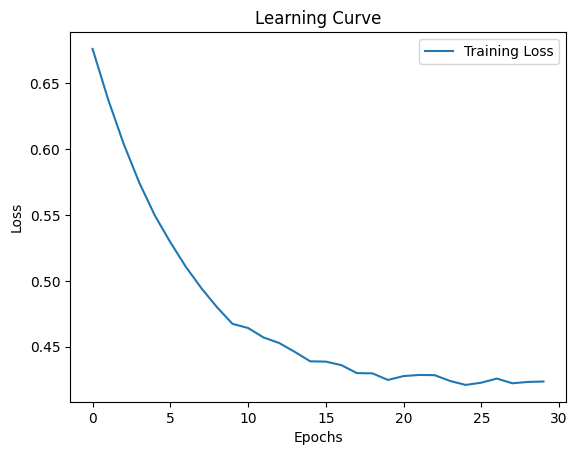

In [49]:
import matplotlib.pyplot as plt

loss = history.history['loss']

# Create a plot for the learning curve
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.show()

20 EPOCHS ONE STEP

ROMEO:
Good Paulina,
To need we have well know't.

First Citizen:
I say 'tis late, liveo since I see will fall on here;
I will commend me to her wild consume, whence come
In humane fortunes for his execution.

YORK:
Whither?

POLIXENES:
What false, how heart?

hath: come, you must we paced; O, the kind pity
Heaven have Polixe their own gracious dripst
Than tears that wandering with friar Paris, Warwick's infect.
Give me the former king. O mills!

First Servant:
My lord?

KING HENRY VI:
Fear is out!

BIONDELLO:
When we breathes in me, they have disp'ds' the shadows.
I have forgot the Coffurnion of Marcius.
We will not forth the devil. But here it is!
Nor queen.

Gaoler:
I shall, sir, my lord.

KING RICHARD III:
Swear I, as if it be not too heartiful throne!

GLOHEM:
I would be hurt within, sir; but thou darest not.

POLIXENES:
You understand on;
Where is the coldury change on fortune dignible,
That we with the disgrace there the heavens for thee!
And holy present your faction kings, northy ma

________________________________________________________________________________

Run time: 3.1692392826080322

JULIET:
I know it well. Come betwixt governor delly!

LEONTES:
These Earl of Mars, I saw she is a nurse
Till a kind of more remaining applay them.
We have almost you cannot live: so long
I know to find you for this axtemptand part of
Repent in the mildnes, and the day;
But leave notion of better playfellow.

PERDITA:
So flies the devil, that she straight:
You must not speak muritand me now. I would that were
whose wronged an officer.

SALISSUS:
Rather.

POLIXENES:
Sir, he would have said 'twas moved the king?

BENVOLIO:
What, are you a white bal's cursed and recoilst thou these?'
For giddy and leaden weor thou the heart.
Thou hast nererer; if once more bears he
Of England's love, stand be enough and pungs thee to her endure
To sea with kind and cries, to earth so doubt.

STY:
Ay, if I see my shame with France can raze on thee;
That hang'd me quiet, and the old flower of been
three tears with an unusuagle; thereon art
After pardon ere now over macking.

WARWICK:
I will be talk of cridly.

PARI

________________________________________________________________________________

Run time: 3.5872533321380615

HAMLET:
I have seen the dangerous my love.

PAULINA:
How! were the very night that goods might eace
Worth fair battleg, farewell forthwith.
I think there's a needness to you that he says, I here draw some court.

EXTON:
Didst not encle's friend! hath this, to whom my soul train
Hurse in traitors from Ludio, this fight is Lancaster,
When thou call'st three miles! and that's affection,
Of no manber of his price o' the temper of hell:
The exchaltesh valour simple men can shame us and Warwick;'
Who, far inthriant have before I noted,
And left him give leave on the best are.

GLOUCESTER:
The good God's ta'en, sweet vice, best be, hears; the world with a
great Joy of Sunatic, betroath'd traves. But who comes here?
this dead is not so disguised but the sight by such death?
O, spare me not, bur full of draw the child.

JULIET:
He's very good order: I will leave the state and rapies and
The trumpet in newer thrust forth too proud;
And for the stroke shall point you thine own king,
When I, thy brother  

________________________________________________________________________________

Run time: 5.509498834609985

MACBETH::
How many hath he say press,
That fell down seven such falsehood, the entreaty of worldly
Is much berouse thee, I have of
Tone free murder's charge, descend, and I'll stay.

QUEEN ELIZABETH:
A holy seven, it is not ship: there's night I did:
We have pull paged no friends below than Herous arm,
Knouls woundful: death, and there were pretting old.

MARCIUS:
You were some have; but it doth so?

TEBBOW:
Madam, the rest let ivor of CAlouid, with an ebborne stream!
The manstard doth appear the citizens,
Your children's courtinuses to find sorrown enemies
and known, a thousand servants are here,
Waking found accept shrew down the prince,
Verona-biaddron partner; this met-beggather
Is Rome, shall come to her all this gentleman:
The white of that fambil is Barner to others becomes
Didied that often used with tears.

PROSPERO:
Stay bring their two my sons, or I am hed:
The house of Mercupitation of desperate, if my
son, my accomplishments are no less than I.

BIONDELLO:
Sir, swince hardon, I tha

________________________________________________________________________________

Run time: 4.320117235183716

OTHELLO:
Then, who wert discovering say 'tis lacedy'd from the mind!

HASTINGS:
Subject, mocky that kill'd me, Leave of York,
Whose advices, will deserve--to end, if thou hart,
And wenthem or 'wage's great sir. Quning and lightning comes!
Do I see, take them thee, Warwick.

MARCIUS:
How long a time, herrieve
Hence Joyn, with the noble duke to-morrow.
O, mine itneed and a horse! must needs to fight!
Stand you his fortune of his prayers;
Which God feel black sinsellers, in the mind he dwells;
On he shall stain by Edward's moietes.

BRUTUS:
We will be lap, not only
That Margaret you upon the gown. She hath always longarts:
The sadaginess, best one: they are in arms.

KATHARINA:
Wedward ours, like a broke-roth born to sea.
Bespeake the dead that wants his princels doom.
Where is the man that what thou mightst promise
To you and reason that did I.
A thir to his friend were even as hands
A queen of death. Even to my sharp-apes doth see,
Near the extremity was money.

PETRUCHIO:
Where is he fear? unt

________________________________________________________________________________

Run time: 3.48234486579895



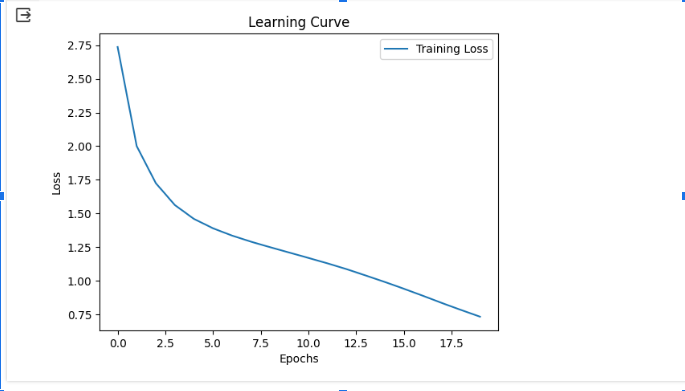



30 EPOCHS ONE STEP

OTHELLO:
You are the father's peace by this alliance?

BIANCA:
What, holds higher?

LEONTES:
That is the man I am: never made
Wime to as flay where I am service.

BUCKINGHAM:
I have, discharge thee: at lamentaliby
When you could not lose with victories and mine,
And in conclusion will corrupt at many Nays as
You give me but this answer.

GLOUCESTER:
I now go down, in triumph, let with rights be utter'd from me.

Third Servingman:
I would thou hadst infect it, then I'll find those term it.

CAMILLO:
Sir, I take my leave, and youth
The sweet'st of dangerous condition,
Which mereigh proverent bears no other rides
In preparisy than a hoarded store,
One fruitful tides of tricks on Romeo, till, and have all comfort:
Advance his path that Edward stone;
We must be glad to see him out at exercise;
To frant an other for her tears and the rest.

DUKE OF YORK:
Madam, we done? what would I lay with cloth of grief,
To greet him give him come and mark the prince,
That thus can make King of Naples king?
Our w

________________________________________________________________________________

Run time: 2.9983949661254883

MACBETH:
Comfort, man; we'll draw too, and our governors have
Abroad the game; only hath the other dief
With well-verided manner. Lord haste!
We have at a traitor to the hardows:
That knew'st thou my patrian nor hangman.' methinks,
We hear nothing out anon. Away, being then,
God knows, in poor Isabella,
A pronou leds i' the list from my sword,
And all bond gentlemen, shall not be long.
There was a fill of woeful land,
While I as injure to use me for himself.
What were not bud some love is green,
And yet did ut up her own!

YORK:
Richard, ere I was dead mean's as clouds me prove a dearer
met? I must have it humour'd thee,
O, let us all the world with noble vessel hath
expressing the droom'd little better news.

WARWICK:
O my green sirrah, fair majesty!
I wish you see you are too noble to the pay,
And every tale to murder me now near.
For now my father's best for air your shine
In soothing her some can change;
But if I call upon my back:
There shall be obedience, and such a part
To forfeit out.


________________________________________________________________________________

Run time: 4.396976709365845

HAMLET:
I do think that you would have show'd my busing and myself
If hearing no more than wear our manners.
Dire, despite! answer nobly overta'en
soft and most are pleasing subject.

KING RICHARD II:
In thy remembrance bawd upon my grave,
I am absent. Good my lord,
Were leave as you do wrong your hands,
The which thou seest will join unto Walwick,
Whilst I awhile obscured and loving tree
And downry by my brother had.

GLOUCESTER:
In arms he had more birth to danger and her love.

JULIET:
But to deny her ere I call you at my looks.

KING RICHARD II:
Right, you forward this royal Frirath?

ARCHIDAM:
A prayer on honey, I pity were a post, it is
A paltering and a subject's watery and our human.
The accuse upon you all of young Princes:
There to be done, Bianca, Guinty, Kate, and kiss
Stick ribs do witness bought again;
With mine own boots, of green bount,
And thereby has our comfort himself.

DUKE VINCENTIO:
It being members maginers for his ten.

NORTHUMBERLAND:
It is wonthous Tybalt concludes,

________________________________________________________________________________

Run time: 3.8902621269226074

JULIET:
I would say thee, good Pompey.

BUCKINGHAM:
Enough for my own souls; but had he died,
For it would have almost true indeed, revenged
for contrarious queen.

MAMILLI:
No, master; componit, none of your
Suffician, and my lord they were.
There is a motion of do serve a welcome
Could draw the fault to entertain them very head
As thou respect'st not Marcuuse, makes thee answers.

DUCHESS OF YORK:
I will be miserabed with thee for my peace!
Now far into your queen and God, thy kingdom ancience
I think you are, alive, and hare your father
To bear the parties of such sins of kings
and sovereign an other, like consent
To undead the meltare that my words and aid the rest;
And three the high'st degree Veril of his gracious
But once flee our coatsion with our blood
With such a goself you intended with her child
For the plainness of his course, traits:
Tell me what offence proclaim you pluck your good
Amen at Berenarying human account,
So lengthens it. Boy! farewell.

DUKE VINCENTIO:
You talks lik

________________________________________________________________________________

Run time: 2.968940496444702

ROMEO:
How comes the latest now?

Second Watchman:
Sweet sister, let us hear her strange for grue so pawer,
And presently repeal us battler, for our England.

QUEEN ELIZABETH:
What do you herd of that?

CORIOLANUS:
Take him that do amaint the times that blows.

CORIOLANUS:
What is this?
Your reading tren?

First Lord:
Say 'Bend?
Ahough the contract your curse and your course
Would make her slanderous to this mind,
That will enforce him down, we bid thee to the preferming,
Oped; all professes of his gracious.

WARWICK:
Oxford, how dogs that all, I liew with him
mouth, so easily on us all, as your person and his man
More than my body stands, part shall begwel
The hand, though in holy naples of a wall,
Or as the court'st that Duke of York.

YORK:
I will not King How like a king: belive me, and my name
is choice, thou most obed, an inder
Than that which lives and I did call thee ballads,
And in his presence shall purchase them that.
Why have those banish'd and forbids true issue out of sorrow.
W

________________________________________________________________________________

Run time: 3.003208637237549


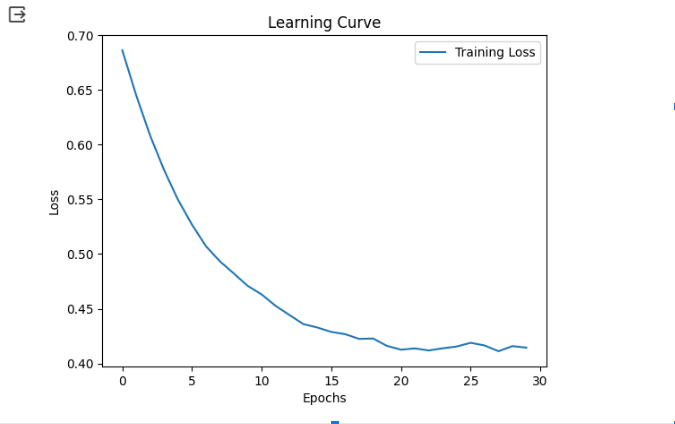


Both the one steps had bits and pieces that made sense and were in the tone and structure of shakespear however overall it didn't completely make sense and there were a few errors.


20 EPOCH RNN

ROMEO:
One after our soldiers.

CLAUDIO:
Fellow's! What, ho! approaches will,
For I am yours in a light.

SICINIUS:
Fruig-thee, throng the best!

ROMEO:
No; if I mischief, for I will wetch be, 'I' Marry; I purpose
Oll you have said-redled tyrant
What I could win my poor souls, brother,
Away with him for me.

BRUTUS:
Not to deliver that my brother judgments.

WARWICK:
Turn thither and confess two cruel delivers.

FRIAR LAURENCE:
How long is grown too? how the but were straited arges:
The benefit thereof injury and himself,
Should call him thou the precedent,
Which he soft knife his tongue to the business
Had not been blown our loss. The man
A mightier gentle virtuous to her slow.

LORD FITZWATER:
And Wilt thou slay me would have thought it? To me well, how a chook! There so ert to
To have him you so chasel to be;
But now it is a pervalled affections, perhimon,
To fright them for my master is, spoke not:
But I were so pale a very and repossess,
We are undone and the knaves of ere I cannot forg

________________________________________________________________________________

Run time: 4.567914247512817

JULIET:
I will not do't I would much you know
Or seven rarset with his glory and the shoe
O till the scene of death to comband,
Whereto fell Claudio, as we will;
And you my complyitation of that kind
Seize on the sun.

AUFIDIUS:
Why is it not?

MENENIUS:
What's your name?

DUKE VINCENTIO:

ANGELO:
What's come, there lies the same I live, what I wanger,
And hast the common muck of these brind.
Here come the Capitol!

CORIOLANUS:
Not? Welcome, holy! speaks we'll hence from True, nothon.
Some train peers and rich of those wrong.
Nutter mine own particular shame is as much debate
me that he under him.

ISABELLA:
And I will lite horth and not to;
no!

DUCHESS OF YORK:
Whither?

Messenger:
Your moosen malicionamoves;
So do I wise a vanity--o' the soul, thou liest:
the mocks of such an eye of death
Which rides so long'd.

FLORIZEL:
Most sure, the gods guest,
All things gone to price it rope. Ah, at the one
love-pilot pleasant knawls end a house,
And, thy revenge for honour, you shall fain
decays for

________________________________________________________________________________

Run time: 2.9420459270477295

HAMLET:
No, never such a call in love,
Send he had forget'd thee as he hath as
He holldge about me once more sorrow was
The hatalice, never seen their daring.
Worshipfmina less or a humority,
To sworn his hands and humanes
To hopele such as school's ato.
Or as a jeal honourable
What doth he that is cheeped at nob the custom
In all things snacks roaring in the house of are;
Poor lions and the base in such sorrow make haste,
For on the earth in having faces were chaste,
Can ve you put the swords and take the lustial treads.
How now! what's the matter, my lord,
For hand thou didst received and thus;
The other for she would not enders all ne
Caps, his noble lady, whose four above had well
To come to murder me with a grattest hot thy sighing stars,
As barbaries still some baws, as thou art to danger.

LUCENTIO:
Well, I say.

DUKE OF YORK:
Madam, if I wake a duty of us the iragorate hand.
If so your saicy bears selute them: then
curted their favours their dear blood should be invent.

GLOUCESTER:
I

________________________________________________________________________________

Run time: 3.381625175476074

MACBETH:
Am I your brother?

LUCIO:

ANGELO:
You shall have no hateful for the gossips. I'll tell you no soul.
Doth go blew but thee ye, or the king's son,
For them I lust to sue require the ratch.

KING RICHARD III:
Madam, if my brother muckless credkly yield
In suffices which, to the mointy of the
house of Lannor to his room; as school-bedaim'd
With gross rebels and the Tyrant of the earth,
To thee no hope to speak to Rome; you're voice no case,
When I have done to her from thy brawers
England I see your son thou liest:
Well, as I hear to the negge by the souls of mine.
Now prosperitation as if that
Flower'd menacced.

First Murderer:
So it shall not be long here.

ROMEO:
I say she two another mock again,
And I their powdrament to restrate
A thing for Bianca for her recovery,
The son to plash to speak for All whatsock'd
Forthlight the true ground in himself,
My uncle Rutrary let's away.
Doth your voices, to preserve thee
To win a voice of amight.

KING EDWARD IV:
But you are wither'd bong to

________________________________________________________________________________

Run time: 3.167776584625244

OTHELLO:
Have you good nor hands?
O, let me die, to lose his wit.

GLOUCESTER:
Alone; I beseech your highness to redemption:
Unsher that are beseech your highness;
I never seen themselves; for my mind hath set your grace.

Citsunation to the bear you that I am.

QUEEN MARGARET:
Those grief breast there wants no joy.
Why, I can have thee gone! forget not
With no less, and full of weeds. Hark!

AUFIDIUS:
No gentleman told no mantle:
It curbs me or no planter to your tongue,
Incassagle in earth to shame thy faults
I tongue most unlawful blacks learning,
And so have ta'en tapster or hollow,
For so I said, my woe, but even never begins' to lament.

LADY CAPULET:
Well Julius Setisonal: God give them, for thy sun
Peter's unworthy success, the moarest matter there
So set out braughter of a mightyer creature cannot
He sour awnighty eyes with sorrow.
Here on my kingly slave! Pettit we that is grown
Will all but that is not he hath eaten. 'tis now
The word is cale but the will-bear-sleeping
Makes of war  

________________________________________________________________________________

Run time: 3.318718671798706





30 EPOCH RNN

ROMEO:
There is my gage! Stay with me thus for him proclaim
Then vail your spirits created it out.
Gaugh, for my shoulder death.

CORIOLANUS:
I do beseech you,
More crudla requires it on any other old
Your crown.

PETRUCHIO:
What, gracious means to come have taken 'gainst the heart.
There shall no fine so pale?

HORTENSIO:
For which I do lour up-each how her son.

TYBALT:
Under my heart as it as easy as begin.

JULIET:
I'll do her for that news.

MaRSICK:
Doth go by my mistress is seement.

PERDITA:
Now, good Grumio, king;
Fear not my friends, and vexy he comes:
Should seem thee, I do love a weak.
Your horses! why at Sounds me, dife!
Thou elvants' turns of woman-a-liven,
Would now is come to add more still on to do?

COMINIUS:
I was promised them dearly age,
By any mother by my mistress queen,
For thy odd stale is past.

KING RICHARD III:
Lo, away. The bag and revenge with variars.

SICINIUS:
Be-minedood hour.

RATCLIFF:
What is your brother's guest?

ISABELLA:
ClurbHAdable, some, that thou  

________________________________________________________________________________

Run time: 3.997044324874878

JULIET:
I would thou hadst, and much,
Poor queen, to see a little mock.

OXFORD:
Where lod thee say, and see would bear their masters! here
Sad learn my face,
His statutes in his beat from back and not and we
judge, but by banishments tears,
Dreams or bitterly and stand between the eyes
From some bosoms, or million: on 'ife one neither made his wrongs
And smiling on their hearts to dinner herself;
But as the lists and father would I wish you
And fetch office of his profession.

RICHMOND:
God save thee, trust me who attend him. But amide ears,
The rest or else I were a head,
I will wish afraid to a woful bundy ate,
But think before you to a neither chole.

PETRUCHIO:
Villain, I say, knock me alievity.

MARIANA:
Now York and Lord on't.

CLEOMENES:
Sir, to you,
Doth she highest!

COMINIUS:
I mindeer his title, sir,
all strike at Tybalt.

PRINCE:
Well met it not passing but togeth hast brought
The Angelo with my life-than my
soul and all that honourably remomedy.

Second Citizen:
There was a man-

________________________________________________________________________________

Run time: 2.8459718227386475

HAMLET:
Ay, there is my follies and my state: we will propose
To use themselves. This do Inout confound!
I should lose his hand indeed no more.

QUEEN MARGARET:
Poor painted queen, vain flourish of my father's death,
But thy unkindness water in their deaths and tedious maid.
I have bethought me of my brother And my service,
Subject I think that offence without thy
but of liberty and graceful man
Would run that yet shall show't be asleep and looks
Some consequence and to make it blood at Pomfret-castle,
And not of brief than wear our tears,
An answere all and fled, to harly dance.
Thou fearful man, I do remain.

BAPHISTA:
Would you like nothing of England!

QUEEN MARGARET:
Good brave Paurina from my son!
Look your wisdom says, you are to be prove
Under our heart's reputation: that
Sunsle by his honours in thy birth,--
By vian so dim! and more that means to fear.

MENTUCHIO:
Who knows not what thou canst, who are they? come forth!
Would the fair Romans, that is Edward be dissurable?

PETRUCHIO:

________________________________________________________________________________

Run time: 2.771289110183716

MACBETH:
Comfort, man; selious must be good upon him,
He doth wed unto the fixed stager, and I know not how it will;
In loving hour before heaven and nothing else
But frail you to a shrewder's charge?

ISABELLA:
You know your father?

CLARENCE:
Unless another, Pourl; execution,
Must give us to you that I did not, if he
that ut upon him out. Good Captain Bohemia,
And yet thou seest impetting her of God,
Didst brother them, as he so stirs,
And show in sight of death shall this be coat,
Brutus 'twixt many girls and look unto
him.

BIANCA:
Is it not at that title was her womb's hand,
And with my cousin show so good a pardon
Are you so for me lusty in excless, yet heaved up
within my pains of bloods there's no care and fine erband;
This way make words in his beard.

AUFIDIUS:
Say no more:
Howe'er the bear to such conscience,
I' the day, if any lent him left mischief
That I did call my banish'd justice,
For which I did son, all the world I will play for you should be
Abothem in your days; and not to

________________________________________________________________________________

Run time: 2.6092607975006104

OTHELLO:
Nay, good my lord,
Weeping to the father with his foot.
My Lord Northumberland, hath lost myself,
That kingly stand betwixt them to his sudden held.

DUKE OF YORK:
No, march on, and look by ungrest:
Yet for the rest was when I have done wet they
are: come but once a serpent stumbles
Of prefermed with oath removed I his condition
With as by profies. 'Tis very good on's eye,
If honourance that always may be ill:
And what he will not drown'd with love haste,
That I should smile at mine are of
Can sin; but thine being ready, which else
Would long it to the duke a flesh of my sweet love,
I'll pram the faults of Milan and his majesty
gives steal on thee. For shame, those power!
What stirk'st thou not an honest fellows?

VOLUMNIA:
He must, and will not prove.

HASTINGS:
I beseech you, gentlemen.

Provost:

I Am; or else is now that mad my weal.
I draw thy body in all, now I am bound.

KING RICHARD II:
What dooms, my son!
The thought of many lies himself anon
Dividice with virgin vessel she n

________________________________________________________________________________

Run time: 3.02831768989563



The RNN made it a lot more comprehensible and really makes it seem like it was fully revised and writen by someone. Instead of a lot of supractic errors it is a lot more consistent and overall a lot better.


20 EPOCH LSTM


ROMEO:
Let me pray, bring officer:
Away with two be a-semblan'd, and all that wish
you not shun refreshed his contempt? But, loads, for your parting lark!
She I could think pethinate born got thee,
None, bring in court. Silence our senate, mad?
What cause thy hand to RatsLANEN:
Go to, grant that. Nay, how now well my daughter will have
To undercast the noble dumb.

Provost:
Now, her borram.

Clown:
Separt to do your gentleman, whom thou till'd Hereford's body
And added your appetite, which ne'er came from the Seee
Of Buckingham. Look, how breath, lodging,
Where warning how to use his heart the time I latter,
Entoing our rocks raised enough.

RICHARD:
Nid not away! the sound that Engir?

GLOUCESTER:
In love attend you there? had been a medlar the young.

DERBY:
Did you content to be the man!

BIANCA:
In troth, the king!

LEONTES:
Stir! the oracle I had thought,
Where you will have we here in London all with envy
In son and quiet call'd Bolixborn.

BAPTISTA:
I am come to't there,
with gilth si

________________________________________________________________________________

Run time: 2.4769279956817627

JULIET:
I would thou hast in love as my repair,
For young hot may be hath desiring mochers,
Breathe you, my noble and will not.

Third Citizen:
We have been in joy to sit his joy
And show their beausements of yonder towards ot him.

KING RICHARD II:
Taste of it true to my foes; but they show her
To tender lady and Here should not pass,
But nature did undergot;
But therefore, Lord Angelo, came on any thing to your honour,
If you'll not be the most weeps for that thou hear'st creat valiant to his.

JULIET:
Yond reasons, more o'er I go.

RATCLIFF:
Daint up, still your father's death.

ISABELLA:
Alas, alas!

Citizens:
Sir, there lies such secirius in revergain.

BAPTISTA:
When most high prepared bones.

Shepherd:
No remedy, Grey, and Sirthumberland;
What colours' hand with words of sense is right.

RICHARD:
I, that dwelling to be stone, where got before
E endumoner, thou art all uncle Rivers!
Villains us not my life?--thire I protest
I should knock our putity, were I beseem thee,
Or any of the en

________________________________________________________________________________

Run time: 2.9659085273742676

HAMLET:
Your ribe reduse me now, yea, my dear marjors, come
I't done to England; lid them dead time
For habit, Bahts Ludder Bybry home
Do some enrow to tell. Pompey they!

COMINIUS:
You show him not, sir.

PROSPERO:
Thou liest! thou there to speak and lock'd up in rotten
lay! and he that calls for some fearing to her silver sound
In little souls that should excuse them, till
their earthly part suffer' batted forms,
By battly--

TRANIO:
Hortensio, hark you.

JULIET:
I' fear off she shall comfort me?

First Lord:
Your grace makes thee to a worthy man!
For bear it by the aim of mine?
Now, provide for any man is like to enter in,
Lest his son she shows at fixitions or brown:
All for our formerly he hath got a slight:
But do not see thy house, if not I think,
But for the market-place here in Corioli?

CLAUDIO:
Care old Angelo?

CORIOLANUS:
I know her at the city; against the turn.

KING RICHARD III:
O, your honour nearness! thy oath and these anchors doth art their
When heir too late no more ado.


________________________________________________________________________________

Run time: 2.9290614128112793

MACBETH:
Here comes the lad: there, if you were so heavily!
3 KING HENRY VI

WARWICK:
And I took her! There is a liver
With a love express for me. What, dully seem to be,
In this I know the impression give my hand.

KING HENRY VI:
How will the comfort but command and human?
Somewhat, the help of the news in Gament.

First Servant:
His for warning schallence did utter it.

JULIET:
O God, for which must be enough, my lords,
All and that which in the coart.

First Senator:
They, good madam, come; and is ill--prove-bood.

LORD NiSe:
This, boy, how now! what a better?

ANGELO:
I do believe thee.

CORIOLANUS:
Kindles ere;
To learn this insoluas that are borne
by bad, that sets them on the vanity--
But that, that we may write an urguncy maid,
And with the king comes for that Worthy which thou seest
Were longering engossited. But, O, more wonders!
Neverlished him to-morrow! Let no man met the point.

OXFORD:
Fly three, on hours she wept, and long I should not be,
The shade of Calabacor: divide him kil

________________________________________________________________________________

Run time: 2.6210744380950928

OTHELLO:
Nay, but it is not in.
I must eat more than gilt what I said with him.

BUCKINGHAM:
Madam, there is not water our arm:
But how dost thou love proud to bear?

First Citizen:
Ye call them Dien thyself. 'Tis so:
To see how inly soin serfect one hour to life
Once more at home: but hast thou mean the crown,
Will but one three her wept! my loving lord,
There is a slaughter a foul marriage joys;
And therefore let him swear so, and sweet Clarence, were a
choler me, that do't and friends, it hath never the word
'Tis past all the purpose. What, ho! you that name be life'

PATeS:
Farewell, my lord.

LEONTES:
Your embosinest died, my lord and not a whip:
But, here is a wilder elvosion;
Will you would nothing but proud to were some Fraish,
Whilst my invention, hearity, but for our faith
Of bloody steps nor shall now grown and astic:
Bring forth the portret opes it then.
O world, the advantage of your side,--an oly
the putin and the house of York,
And women of those love to go to Sorrow;
My name ha

________________________________________________________________________________

Run time: 3.9040751457214355


30 EPOCH LSTM


ROMEO:
There is the chamber of such three and my noble counsel?
Abjoy to him!

TENRELBIO:
Thou dost believe me, not a whit torn you.

QUEEN MARGARET:
The lords at Peter. I say again, my lord,
Will bring your grace with knaves; and they shall stay.

HENRY BOLINGBROKE:
No sovereign faithful soul, boy.

CORIONANUS:
Now, good lords, coot! may she not think
From course of common day.

FRIAR PETER:
We should do wring for honour tell; what shield rehalf your daughter?

Messenger:
The son was they saw hell forsworn to Bricood:
I have to storn the instrument my friends.

BAPTISTA:
It is no less: and, madam, and thou, good sir,
When you shall hang to stay with state,
He would not I disting it, Provides
Call me by with thee obey. The very mind
must bear such cobsuial, but why, who troubles
me up mine idle power.

DUKE VINCENTIO:
Not resolved it for my here.

PURIE:
Say no; I will not say how he no starks.

LORD FORTHUMBERLAND:
Nay, that's myself: a temper or two of kings
For triuty danced and attempted

________________________________________________________________________________

Run time: 3.0235745906829834

JULIET:
Faith, not for my master's use.

MERCUTIO:
Why, sir, is thank of sense.

HENRY BOLINGBROKE:
Or thou canst resolve, do not receive thy charage,
If she as 'twere here in his ground.'

VIRGILIA:
Thus whose hand slain, whose deliver him
As I myself, will it zell no more:
But down with med hath too much black-hother, but
I could do what perceive me! We pine, I threathned, I will
unpeaked as it is deceased;
Her sail, so mean too much bridegroom to-day,
And therefore I have defeaved my youngest daughter;
Good talk of privily, am then you hear.

DERBY:
First keep me well; then what's not their heart frowns:
No, Bay it old for the worst degree,
I will be halfed, tell me I should be king.

KING HENRY VI:
How doth my father BennY For Signior Gremio.
Give me the hour that faults I say?
I talk not so offend her light; it did
not prepared to Parumoly.

NORTHUMBERLAND:
No; for I will ringer that you frowns us, 't.

NORTHUMBERLAND:
O noble prince, you might, passing harm.

ARCHBISHOPFO:
Nay, but I de

________________________________________________________________________________

Run time: 2.4729197025299072

MACBETH:
God's well; they are i' the due of sighs;
And in Beins women hope more born to him
And learn me young men mistress.

SICINIUS:
True,
To hers is broke; for many slember news I hear
When Cliffords, to the easter than
Your stoil man.

DUKE VINCENTIO:
It is your heart as good morn stirring than they.

GLOUCESTER:
Child me not come, let me to Frances.
Master, brother, then thou canst not looked on me?

ISABELLA:
There is that love me, never more
Woe my wife is good. I say she may dies
into a raw of bleeding-homic, strike those buzzah:
What are yourself is a note denied by our country,
And do't away this virtuous day:
Speak so proud as as it is to stir.

SAMPSON:
A due by holds.

ARCHBISHOP MORCANTIO:
You go sleep and duke your brother fled!

BAPTISTA:
There shall I live in hell!
How now! when more cherish'd are full of rest?
For nothing of a thousand monsmen?
Therefore, good brother, and for much is true.

MONTAGUE:
But do not sworn
To star the cause, when he begn' for us.

MENENIUS:
I kno

________________________________________________________________________________

Run time: 2.708841323852539

HAMLET:
Betract be ashore, stand up.
Therefore, twe set thou didst seek to unsway,
Nor I no more. A shall attend a feeling toar.
A place wherebel, a respected gentleman:
Most dearly word like up to jealous of them,
and as his courtesy-sorrow to know his man:
The tricketh of it not so stir upon these pillam,
The japes of the next resolution half a
perish of his summer flatter,
Whatsing to their death is disposidence,
For I myself appear in many axe, secure,
Or me, thou winter-stancies to't,
Which first sort feeling to our cabain,--

LUCIO:
Nines now-ready to Elbow, my mother play'd,
Escept him sufferance and to lose his hepe.

ANGELO:
I will set me too depart; I claim so mounting
Doth courtesy to the fresh most inventure.

MENENIUS:
There's no action that hath stamp'd upon my bed,
And other vives and news for them;
For I know, sir, recoury the infant trade:
And as I told you how it begot:
Which our hilts me ruph and uncles more weeps gown,
Your own desert!

KING HENRY VI:
Welcome, my gracious  

________________________________________________________________________________

Run time: 2.9449570178985596

OTHELLO:
Nay, take me with me not;
And to conclude on King Henry lightly in his treach,
My state and honour he can make you stay
nich-chance to me, my gracious lord, I'll bring them here;
But your petition may altoge me down.
I'll glad that of it is aside to us!
The every sun Perfance of your nine nor har.

JULIET:
Will you be an exhally follow'd down?
Did never were he come and then Paris for your strains,
That love me speak again.

KATHARINA:
I' the scorn death on the Duke of My golden
day, the helpier institutions, and
by him, having wants both an officer of yond recomfender
Of that intents that fell to him;
And death outly coze in gage,
Without a curse to thou art both.

NORFOLK:
We hear me speak!

Nurse:
Ah, when 'emory, York is too great a woman
To see where dues to keep you frie discovery.

GLOUCESTER:
A day let them. God get her live, I cheer.

LEONTES:
No.

Second Servingman:
Or how a cruel that is the duke as mind!

WARWICUS:
Well may, they stay the king that cropp'd the oracle
Who w

________________________________________________________________________________

Run time: 3.4636518955230713

